# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('./Data for HW 3/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('./Data for HW 3/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)


# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000L, 126L) (1124L, 126L)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [4]:
def P1():
### STUDENT START ###

    k = range(1,51)
    
    for each in k:
        pca = PCA(n_components=each, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
        pca.fit(train_data)

        print("Fraction of Total Variance explained by first %i principal components: %0.2f%%" %(each, sum(pca.explained_variance_ratio_)*100))

### STUDENT END ###

P1()

Fraction of Total Variance explained by first 1 principal components: 16.40%
Fraction of Total Variance explained by first 2 principal components: 29.73%
Fraction of Total Variance explained by first 3 principal components: 39.90%
Fraction of Total Variance explained by first 4 principal components: 46.96%
Fraction of Total Variance explained by first 5 principal components: 50.83%
Fraction of Total Variance explained by first 6 principal components: 54.51%
Fraction of Total Variance explained by first 7 principal components: 57.64%
Fraction of Total Variance explained by first 8 principal components: 60.37%
Fraction of Total Variance explained by first 9 principal components: 62.99%
Fraction of Total Variance explained by first 10 principal components: 65.22%
Fraction of Total Variance explained by first 11 principal components: 67.27%
Fraction of Total Variance explained by first 12 principal components: 69.14%
Fraction of Total Variance explained by first 13 principal components: 70

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

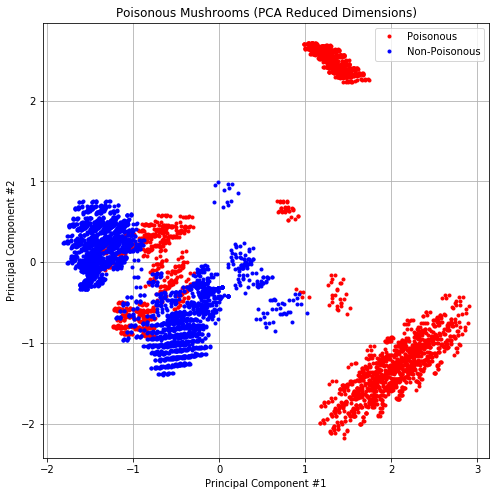

In [5]:
def P2():
### STUDENT START ###

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(train_data)
    
    poisonous_indices = [i for i,x in enumerate(train_labels) if x == 1]
    nonpoisonous_indices = [i for i,x in enumerate(train_labels) if x == 0]
    
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(111)
    plt.ylabel('Principal Component #2')
    plt.xlabel('Principal Component #1')
    plt.title('Poisonous Mushrooms (PCA Reduced Dimensions)')
    plt.grid(True)
    line1, = ax1.plot(reduced_data[poisonous_indices, 0], reduced_data[poisonous_indices, 1], 'r.', label='Poisonous')
    line2, = ax1.plot(reduced_data[nonpoisonous_indices, 0], reduced_data[nonpoisonous_indices, 1], 'b.', label='Non-Poisonous')
    plt.legend(handles=[line1, line2])
    plt.show()

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

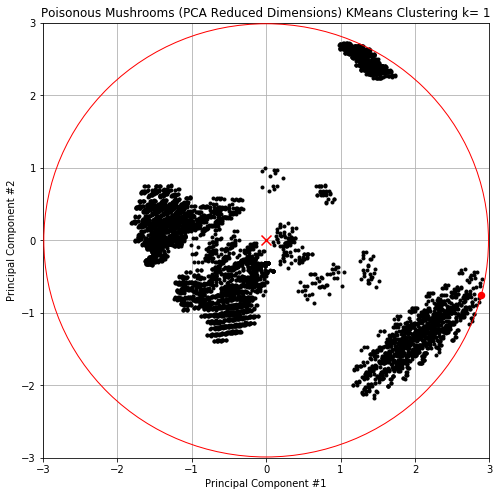

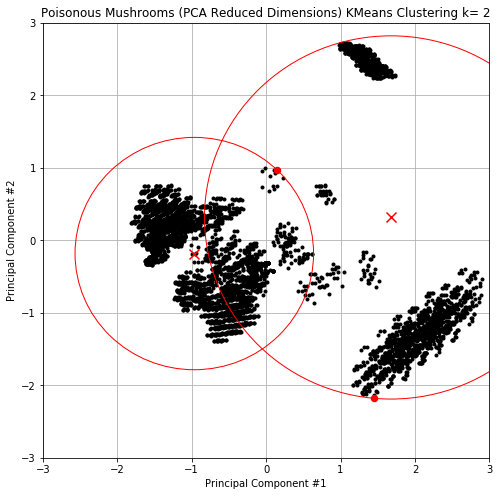

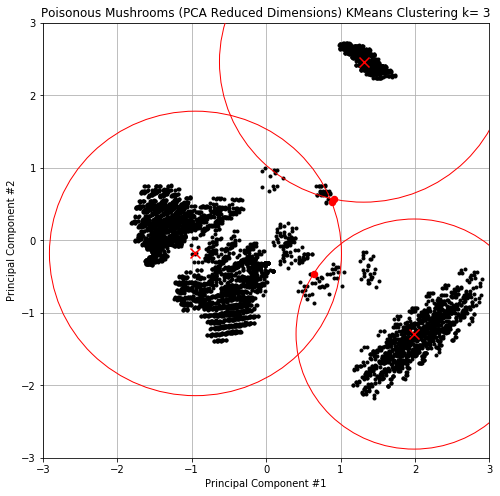

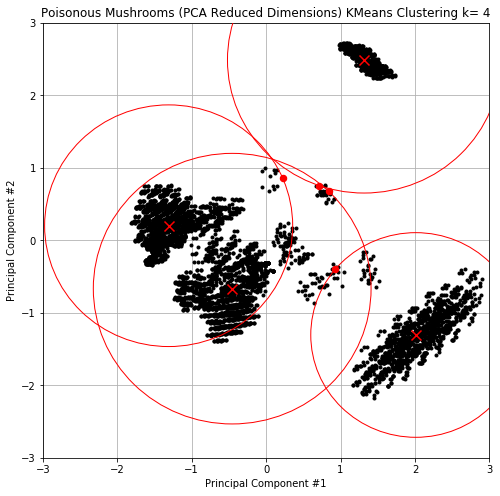

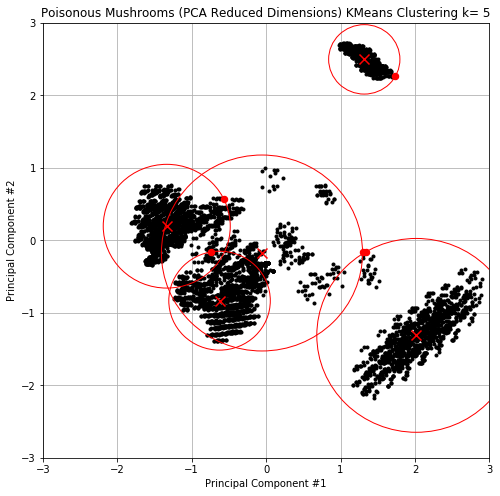

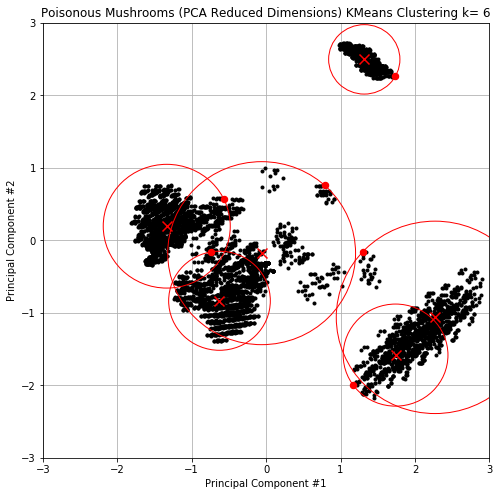

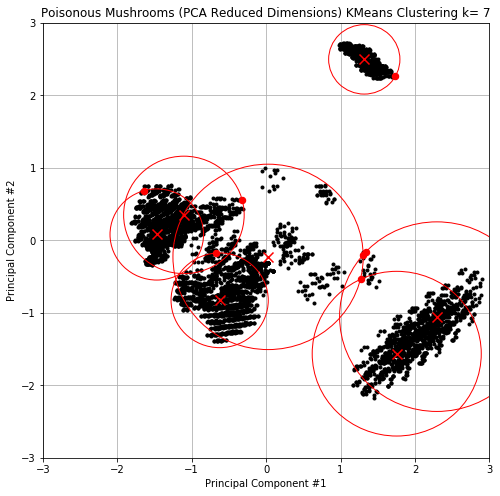

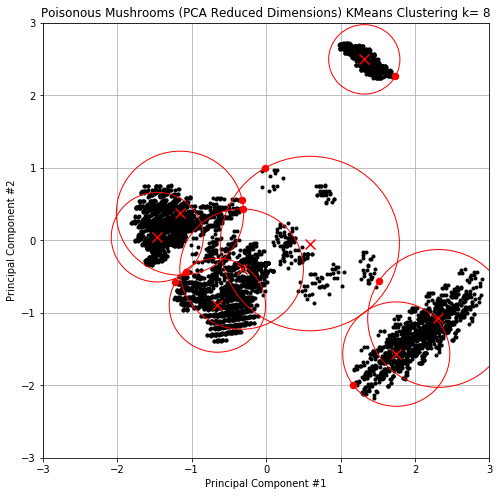

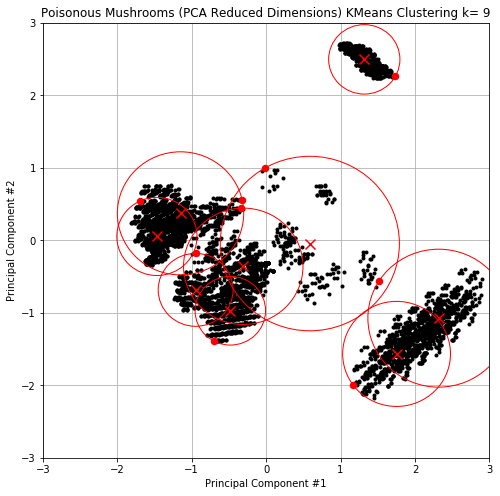

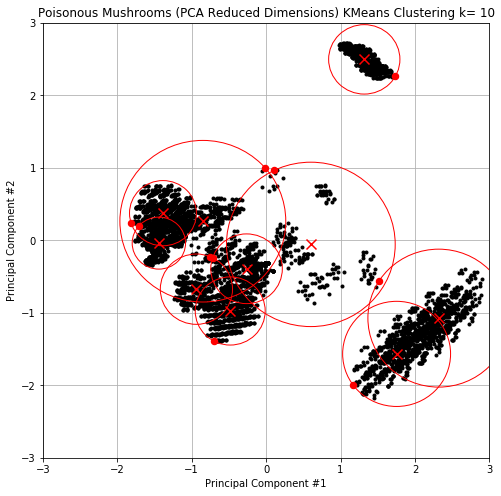

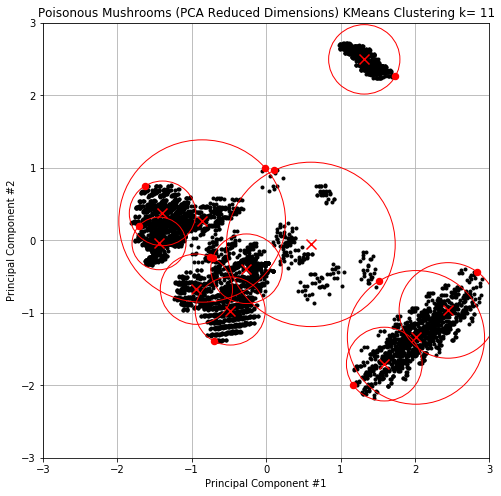

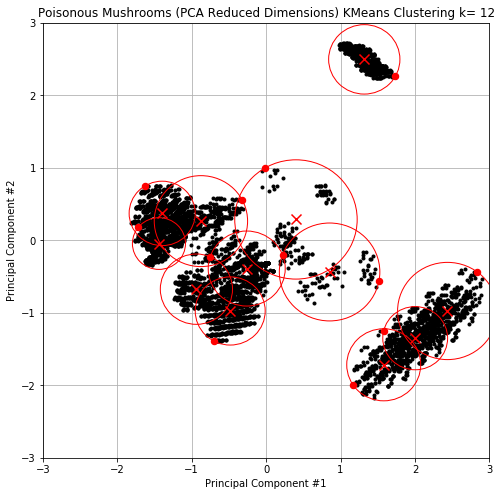

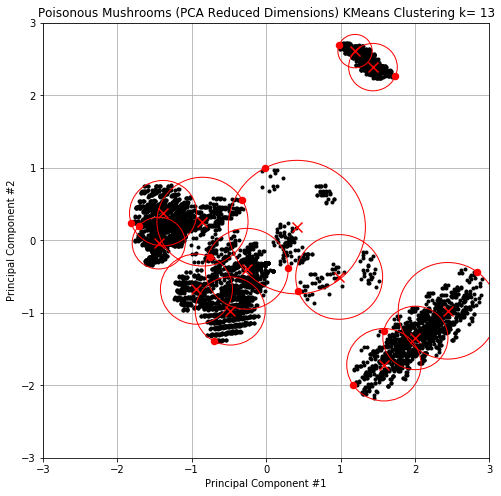

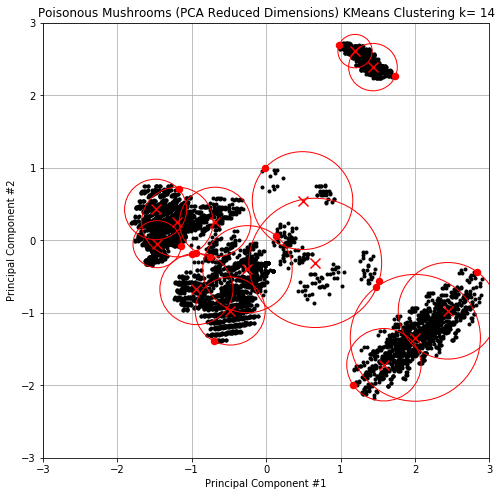

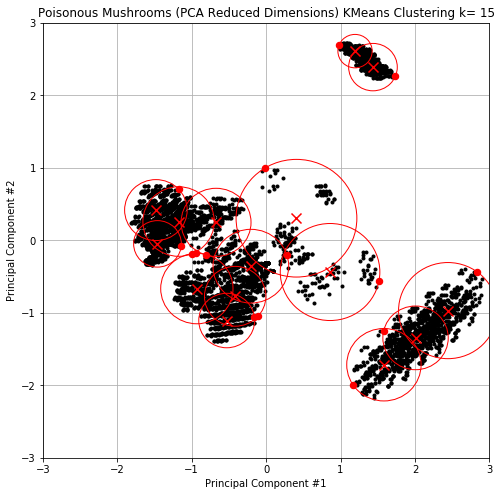

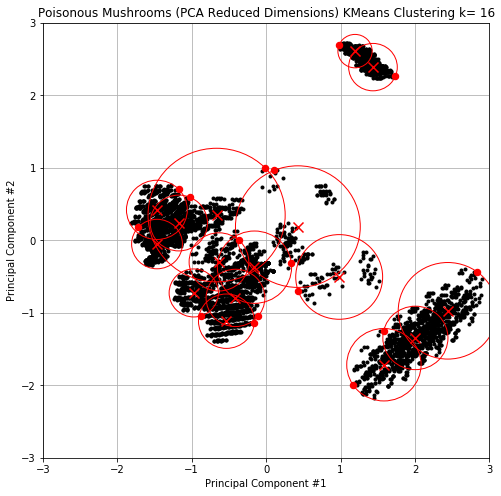

In [6]:
def P3():
### STUDENT START ###
    
    # Setup PCA reduced data and K values to try in KMeans
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(train_data)

    ks = range(1,17)
    
    # Run KMeans and plot for each K
    for k in ks:
        
        # Fit KMeans
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                        precompute_distances='auto', verbose=0, random_state=None, copy_x=True, 
                        n_jobs=1, algorithm='auto')
        kmeans.fit(reduced_data)

        # Find furthest point in each cluster
        furthest = [(cluster,(0,0), 0) for cluster in range(0,k)]
        for label,coords,dist in furthest:
            for i,x in enumerate(reduced_data):
                if kmeans.labels_[i] == label:
                    # Calculate Euclidian Distance between Centroid and Point & update furthest if longer than stored so far
                    current_dist = np.sqrt((x[0] - kmeans.cluster_centers_[label][0])**2 +
                                           (x[1] - kmeans.cluster_centers_[label][1])**2)
                    if current_dist > furthest[label][2]:
                        furthest[label] = (label, (x[0],x[1]), current_dist)
        
        # Set up figure
        fig = plt.figure(figsize=(8,8))
        ax1 = fig.add_subplot(111)
        plt.axis([-3,3,-3,3])
        plt.ylabel('Principal Component #2')
        plt.xlabel('Principal Component #1')
        plt.title('Poisonous Mushrooms (PCA Reduced Dimensions) KMeans Clustering k= ' + str(k))
        plt.grid(True)

        # Plot PCA reduced Data
        line1, = ax1.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.')

        # Plot Centroids
        centroids = kmeans.cluster_centers_
        plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=100, linewidths=10,
                color='r', zorder=10)

        # Plot Furthest Points
        furthest_points = np.array([[i[1][0],i[1][1]] for i in furthest])
        plt.scatter(furthest_points[:, 0], furthest_points[:, 1],
                marker='o', s=20, linewidths=3,
                color='r', zorder=10)

        # Plot Circles
        for i,coords in enumerate(furthest):
            circle1 = plt.Circle((centroids[i,0], centroids[i,1]), coords[2], color='r', fill=False, zorder=10)
            ax1 = plt.gca()
            ax1.add_artist(circle1)

        plt.show()

### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

C:\Users\User\Anaconda2\lib\site-packages\matplotlib\contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


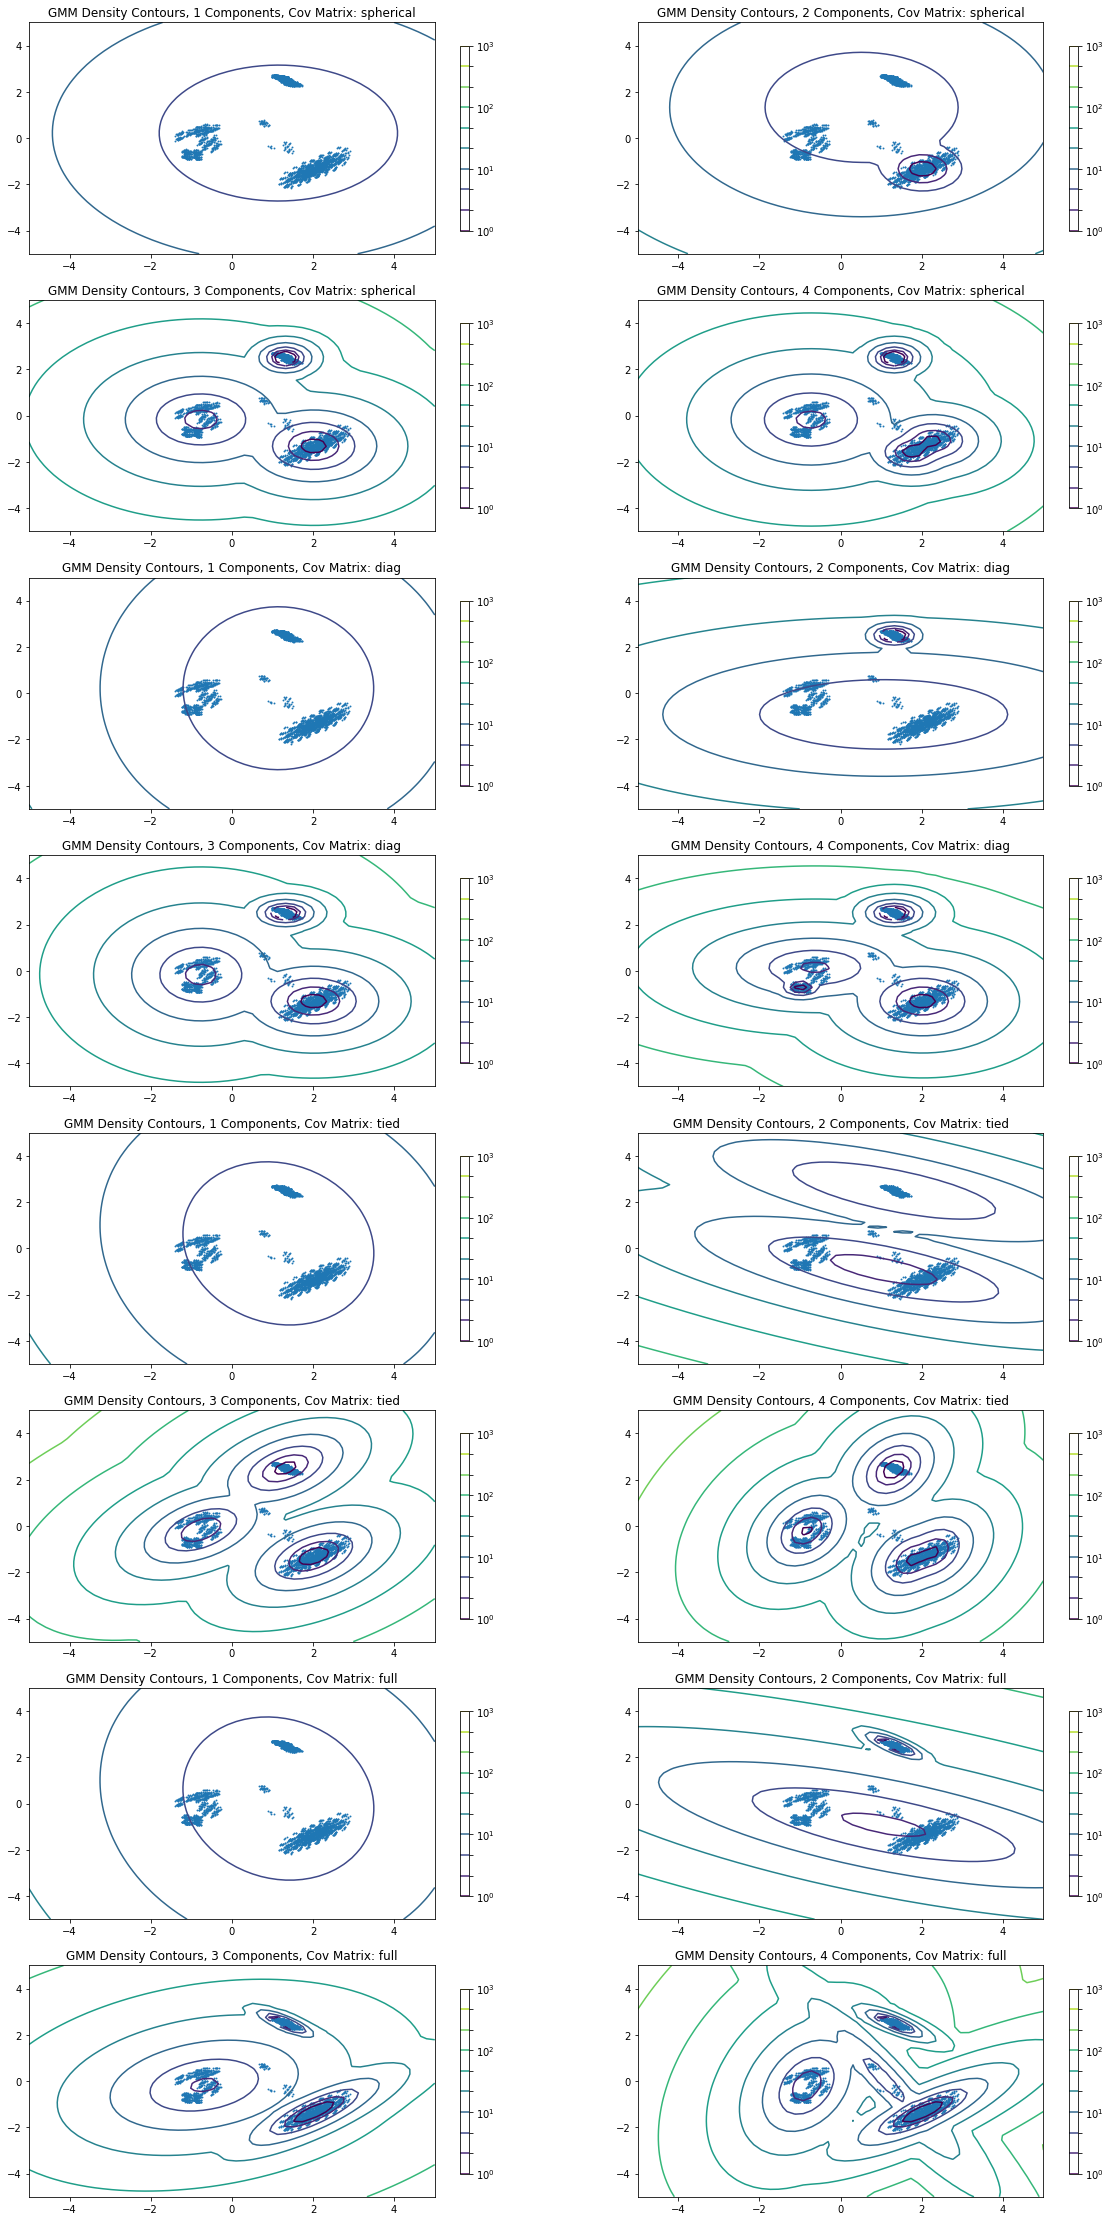

In [7]:
def P4():
### STUDENT START ###

    # Fit & Transform 2 Component PCA on Training Data
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(train_data)
    
    # Identify Indices of poisonous (positive) mushrooms in the training dataset & segregate training data
    poisonous_indices = [i for i,x in enumerate(train_labels) if x == 1]
    positive_train_data = reduced_data[poisonous_indices,:]
    
    # Initialize Figure & pre-loop criteria
    plt.figure(figsize=(20,40))
    covlist = ['spherical', 'diag', 'tied', 'full']
    i = 1
    
    # Loop through different Covariance Matrix Types and # of GMM components (1 - 4)
    for covtype in covlist:
        for comps in range(1,5):
            
            # Fit GMM
            gm = GaussianMixture(n_components=comps, covariance_type=covtype, tol=0.001, reg_covar=1e-06, 
                                 max_iter=100, n_init=1, init_params='kmeans', weights_init=None, 
                                 means_init=None, precisions_init=None, random_state=None, warm_start=False, 
                                 verbose=0, verbose_interval=10)
            gm.fit(positive_train_data)

            # display predicted scores by the model as a contour plot (http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py)
            
            # Set up grid & Calculate Gaussian Scores
            p = plt.subplot(8, 2, i)
            x = np.linspace(-5., 5.)
            y = np.linspace(-5., 5.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)
                        
            # Plot Contours for GMM gaussians
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            
            # Plot Positive Training Example Data (Poisonous Mushrooms)
            p.scatter(positive_train_data[:, 0], positive_train_data[:, 1], .8)

            # Plot Details
            p.axis('tight')
            plt.title('GMM Density Contours, %i Components, Cov Matrix: %s' %(comps, covtype))
            
            i += 1


### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [10]:
def P5():
### STUDENT START ###

    # Fit & Transform 2 Component PCA on Training Data & Transform Test Data
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(train_data)
    reduced_test_data = pca.transform(test_data)

    # Segregate Positive and Negative Training Data
    poisonous_indices = [i for i,x in enumerate(train_labels) if x == 1]
    nonpoisonous_indices = [i for i,x in enumerate(train_labels) if x == 0]
    positive_train_data = reduced_data[poisonous_indices,:]
    negative_train_data = reduced_data[nonpoisonous_indices,:]      
    
    # Positive Examples
    gm_positive = GaussianMixture(n_components=4, covariance_type='full')
    gm_positive.fit(positive_train_data)
    gm_positive_test_predictions = gm_positive.score_samples(reduced_test_data)
    
    # Negative Examples
    gm_negative = GaussianMixture(n_components=4, covariance_type='full')
    gm_negative.fit(negative_train_data)
    gm_negative_test_predictions = gm_negative.score_samples(reduced_test_data)
    
    # Function to Check Accuracy
    def check_accuracy(test_labels, gm_positive_test_predictions, gm_negative_test_predictions):
        # Create list of Predictions
        predicted = np.ndarray((test_labels.shape[0], 1))    
        for index in range(0,predicted.shape[0]):
            if gm_positive_test_predictions[index] >= gm_negative_test_predictions[index]:
                predicted[index] = int(1)
            else:
                predicted[index] = int(0)

        # Check Accuracy & Print
        correct_predictions = np.ndarray((test_labels.shape[0], 1))
        for i in range(0,test_labels.shape[0]):
            if predicted[i] == test_labels[i]:
                correct_predictions[i] = True
            else:
                correct_predictions[i] = False

        accuracy = sum(correct_predictions) / correct_predictions.shape[0] * 100
        return accuracy
    
    # Print Accuracy
    print('Accuracy: %0.2f%%' %(check_accuracy(test_labels, gm_positive_test_predictions, gm_negative_test_predictions)))
    

### STUDENT END ###

P5()

Accuracy: 95.02%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [9]:
def P6():
### STUDENT START ###

# # of Parameters for each covariance type
# c = # of components, d = # of dimensions
# Spherical: c
# Diagonal: d
# Full: dC2 + d
# Tied: dC2 + d

    # Function to Check Accuracy
    def check_accuracy(test_labels, gm_positive_test_predictions, gm_negative_test_predictions):
        # Create list of Predictions
        predicted = np.ndarray((test_labels.shape[0], 1))    
        for index in range(0,predicted.shape[0]):
            if gm_positive_test_predictions[index] >= gm_negative_test_predictions[index]:
                predicted[index] = int(1)
            else:
                predicted[index] = int(0)

        # Check Accuracy & Print
        correct_predictions = np.ndarray((test_labels.shape[0], 1))
        for i in range(0,test_labels.shape[0]):
            if predicted[i] == test_labels[i]:
                correct_predictions[i] = True
            else:
                correct_predictions[i] = False

        accuracy = sum(correct_predictions) / correct_predictions.shape[0] * 100
        return accuracy
    
    
    # Create a top parameter tuple in the form (#pca, covtype, #gmm, #params, accuracy)
    top_parameters = (0, 'covtype', 0, 0, 0.0) 
    
    
    # Loop through different numbers of PCA Components
    pca_components = [2,3,4,5,6,7,8,9,10]
    for pcacomp in pca_components:
    
        # Fit & Transform 2 Component PCA on Training Data & Transform Test Data
        pca = PCA(n_components=pcacomp)
        reduced_data = pca.fit_transform(train_data)
        reduced_test_data = pca.transform(test_data)

        # Segregate Positive and Negative Training Data
        poisonous_indices = [i for i,x in enumerate(train_labels) if x == 1]
        nonpoisonous_indices = [i for i,x in enumerate(train_labels) if x == 0]
        positive_train_data = reduced_data[poisonous_indices,:]
        negative_train_data = reduced_data[nonpoisonous_indices,:]      
    
        # Loop through different types of covariance matrices
        gmm_cov_type = ['spherical', 'diag', 'full', 'tied']
        for covtype in gmm_cov_type:
        
            # Loop through different numbers of GMM components
            gmm_components = [1,2,3,4,5,6,7,8,9,10]
            for gmmcomp in gmm_components:

                # Fit a GMM for both the positive and negative classes (assume hyperparameters are the same for each)
                
                # Positive Examples
                gm_positive = GaussianMixture(n_components=gmmcomp, covariance_type=covtype)
                gm_positive.fit(positive_train_data)
                gm_positive_test_predictions = gm_positive.score_samples(reduced_test_data)
                gm_positive_mean_parameters = len(gm_positive.means_.ravel())
                gm_positive_cov_parameters = len(gm_positive.covariances_.ravel())

                # Negative Examples
                gm_negative = GaussianMixture(n_components=gmmcomp, covariance_type=covtype)
                gm_negative.fit(negative_train_data)
                gm_negative_test_predictions = gm_negative.score_samples(reduced_test_data)
                gm_negative_mean_parameters = len(gm_negative.means_.ravel())
                gm_negative_cov_parameters = len(gm_negative.covariances_.ravel())
        
                # Tally the total number of parameters estimated here & calculate accuracy
                total_parameters = gm_positive_mean_parameters + gm_positive_cov_parameters + \
                                      gm_negative_mean_parameters + gm_negative_cov_parameters
                accuracy = check_accuracy(test_labels, gm_positive_test_predictions, gm_negative_test_predictions)
                
                # Replace the top parameter tuple if accuracy is high & total parameters <= 50
                if accuracy > top_parameters[4]:
                    if total_parameters <= 50:
                        top_parameters = (pcacomp, covtype, gmmcomp, total_parameters,accuracy)
                
                # Print run to screen
                print("# PCA Components: %i \t Cov Type: %s \t # GMM Components: %i \t # Params: %i \t Accuracy: %0.2f%%" \
                      %(pcacomp, covtype, gmmcomp, total_parameters, accuracy))

                
    # Print out Summary of Most Successful Parameters
    print("")
    print("TOP HYPER PARAMETERS (with total # parameters <= 50): ")
    print("# PCA Components: %i" %(top_parameters[0]))
    print("Cov Type: %s" %(top_parameters[1]))
    print("# GMM Components: %i" %(top_parameters[2]))
    print("# Parameters Estimated: %i" %(top_parameters[3]))
    print("Accuracy: %0.2f%%" %(top_parameters[4]))
    

### STUDENT END ###

P6()

# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 1 	 # Params: 6 	 Accuracy: 86.03%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 2 	 # Params: 12 	 Accuracy: 87.63%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 3 	 # Params: 18 	 Accuracy: 94.57%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 4 	 # Params: 24 	 Accuracy: 94.57%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 5 	 # Params: 30 	 Accuracy: 93.86%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 6 	 # Params: 36 	 Accuracy: 93.86%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 7 	 # Params: 42 	 Accuracy: 94.22%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 8 	 # Params: 48 	 Accuracy: 94.93%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 9 	 # Params: 54 	 Accuracy: 95.46%
# PCA Components: 2 	 Cov Type: spherical 	 # GMM Components: 10 	 # Params: 60 	 Accuracy: 95.11%
# PCA Components: 2 